# 加载信标

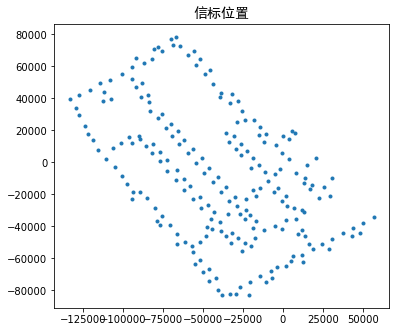

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

beacon = []

with open("280024771-1.txt") as f:
    data = f.readlines()
    index = 0
    for i in range(len(data)):
        data[i] = data[i].rstrip("\n")
        splits = data[i].split(',')
        #print(splits)
        if ( len(splits)<5 ):
            continue
        else:
            beacon.append(splits)
            
#print(beacon)
Beacon_xy = np.zeros((len(beacon),2))
for i in range(Beacon_xy.shape[0]):
    Beacon_xy[i,0] = beacon[i][3]
    Beacon_xy[i,1] = beacon[i][4]

plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("信标位置", fontproperties=fontP)
plt.gca().set_aspect(1)

plt.show()

# 生产ID字典

In [2]:
ID = [[] for i in range(len(beacon))]
ID2 = [[] for i in range(len(beacon))]
ID3 = [[] for i in range(len(beacon))]
uuid = [i[2] for i in beacon]
Beacon_map = dict(zip(uuid,ID))
time_Beacon_map = dict(zip(uuid,ID2))
Beacon_map_kalman = dict(zip(uuid,ID3))
print(Beacon_map_kalman)

{'140': [], '141': [], '142': [], '143': [], '144': [], '145': [], '146': [], '147': [], '148': [], '149': [], '150': [], '900': [], '901': [], '902': [], '903': [], '904': [], '905': [], '906': [], '907': [], '908': [], '909': [], '910': [], '911': [], '912': [], '913': [], '914': [], '915': [], '916': [], '917': [], '918': [], '919': [], '36850': [], '36851': [], '36852': [], '36853': [], '36854': [], '36855': [], '36856': [], '36857': [], '36858': [], '36859': [], '36860': [], '36861': [], '36862': [], '36863': [], '36864': [], '36865': [], '36866': [], '36867': [], '36868': [], '36869': [], '36870': [], '36871': [], '36873': [], '36874': [], '36875': [], '36876': [], '36877': [], '36878': [], '36879': [], '36880': [], '36881': [], '36882': [], '36883': [], '36884': [], '36885': [], '36886': [], '36887': [], '36888': [], '36889': [], '36891': [], '36892': [], '36893': [], '36894': [], '36895': [], '36896': [], '36897': [], '36898': [], '36899': [], '37378': [], '37379': [], '37380':

In [4]:
def kalmanF(data,q=3,r=300):
    evalkk=0#当前卡尔曼估计值
    evalkk1=0#当前预测值
    evalk1k1=0#上一次卡尔曼估计值
    Pkk=1
    Pkk1=1
    Pk1k1=1
    Q = q
    R = r
    kalman_T = []
    kalman_T.append(data[0])
    evalkk = data[0]
    for i in range(1,len(data)):
        evalkk1 = evalkk #上一次的卡尔曼估计值为预测值
        Pkk1 = Pk1k1 + Q #此次协方差预测值
        Kk = Pkk1/(Pkk1+R)#最优卡尔曼估计
        evalkk = evalkk1 + Kk*(data[i] - evalkk1)#当前卡尔曼估计值
        Pkk1 = Pkk1 - Kk*Pkk1#当前卡尔曼协方差估计值
        Pk1k1 = Pkk1
        kalman_T.append(evalkk)
    return kalman_T
def kalmanF_new(rss,kal_para):
    #kal_para = [evalkk,Pk1k1,Q,R]
    #evalkk=0#当前卡尔曼估计值
    #evalkk1=0#当前预测值
    #evalk1k1=0#上一次卡尔曼估计值
    #Pkk=1
    #Pkk1=1
    #Pk1k1=1
    #Q = q
    #R = r   
    #print(kal_para)
    evalkk1 = kal_para[0] #上一次的卡尔曼估计值为预测值
    Pkk1 = kal_para[1] + kal_para[2] #此次协方差预测值
    Kk = Pkk1/(Pkk1+kal_para[3])#最优卡尔曼估计
    evalkk = evalkk1 + Kk*(rss - evalkk1)#当前卡尔曼估计值
    Pkk1 = Pkk1 - Kk*Pkk1#当前卡尔曼协方差估计值
    kal_para[1] = Pkk1
    kal_para[0] = evalkk
    #print(kal_para)
    return kal_para

# 加载实时信标

In [129]:
import json

ID = [[] for i in range(len(beacon))]
ID2 = [[] for i in range(len(beacon))]
ID3 = [[] for i in range(len(beacon))]
ID4 = [[] for i in range(len(beacon))]
uuid = [i[2] for i in beacon]
Beacon_map = dict(zip(uuid,ID))#after kalman
time_Beacon_map = dict(zip(uuid,ID2))
Beacon_map_kalman = dict(zip(uuid,ID3))#every beacon kalman parameters
Beacon_map_raw = dict(zip(uuid,ID4))#raw beacon

time_seq_beacon = []
time_seq_compass = []
time_seq_accelerometer = []
time_seq_deviceMotion = []
beacon_seq = []
compass_seq = []
accelerometer_seq = []
deviceMotion_seq = []
with open("download16_280024771_1640159460000.txt") as f:
    lines = f.readlines()
    #print(data)
    #json.loads(data[0])
    for line in lines:
        #print(line)
        try:            
            res_sparse = json.loads(line)        
        except Exception as e:
            print("1")
            continue
        
        time_samples_beacon = []
        time_samples_compass = []
        time_samples_accelerometer = []
        time_samples_deviceMotion = []
        beacon_response = []
        compass_samples = []
        accelerometer_samples = []
        deviceMotion_samples = []
        for res in res_sparse:
            #解析信标
            if res['type'] == 'ibeacon':
                #print(len(res['res']))
                count = 0
                for one_beacon in res['res']:
                    
                    #z mprint(one_beacon)
                    #beacon_response.append(one_beacon)
                    #time_samples_beacon.append(res['timestamp'])
                    try:
                        if len(Beacon_map_kalman[str(one_beacon[2])]) == 0:
                            Beacon_map_raw[str(one_beacon[2])].append(one_beacon[3])
                            Beacon_map_kalman[str(one_beacon[2])]=[one_beacon[3],1,3,100]
                            beacon_response.append(one_beacon)
                            time_samples_beacon.append(res['timestamp'])
                            Beacon_map[str(one_beacon[2])].append(one_beacon[3])
                            time_samples_beacon.append(res['timestamp'])
                            time_Beacon_map[str(one_beacon[2])].append(res['timestamp'])
                            count = count + 1
                        else:    
                            count = count + 1
                            Beacon_map_raw[str(one_beacon[2])].append(one_beacon[3])#记录原始beacon
                            kalman_res = kalmanF_new(one_beacon[3],Beacon_map_kalman[str(one_beacon[2])])                            
                            Beacon_map_kalman[str(one_beacon[2])] = kalman_res
                            one_beacon[3] = kalman_res[0]
                            beacon_response.append(one_beacon)
                            time_samples_beacon.append(res['timestamp'])
                            Beacon_map[str(one_beacon[2])].append(one_beacon[3])#记录滤波后beacon
                            time_samples_beacon.append(res['timestamp'])
                            time_Beacon_map[str(one_beacon[2])].append(res['timestamp'])
                    except Exception as e:
                        #print(e)
                        pass
                #print(count)    
            if res['type'] == 'compass':
                #解析罗盘
                compass_samples.append(res['res'])
                time_samples_compass.append(res['timestamp'])
            if res['type'] == 'accelerometer':
                #解析加速器
                data = res['res']
                accelerometer_samples.append(np.sqrt(data[0]*data[0]+data[1]*data[1]+data[2]*data[2]))
                time_samples_accelerometer.append(res['timestamp'])
            if res['type'] == 'deviceMotion':
                #解析设备方向
                deviceMotion_samples.append(res['res'])
                time_samples_deviceMotion.append(res['timestamp'])
           
        beacon_seq.append(beacon_response)
        time_seq_beacon.append(time_samples_beacon)
        compass_seq.append(compass_samples)
        time_seq_compass.append(time_samples_compass)
        accelerometer_seq.append(accelerometer_samples)
        time_seq_accelerometer.append(time_samples_accelerometer)
        deviceMotion_seq.append(deviceMotion_samples)
        time_seq_deviceMotion.append(time_samples_deviceMotion)
        #break

In [41]:
time_Beacon_map[beacon[0][2]][0]

IndexError: list index out of range

In [90]:
n=150
print(len(time_Beacon_map[beacon[n][2]]))
print(len(Beacon_map_raw[beacon[n][2]]))
print(len(Beacon_map[beacon[n][2]]))

63
63
63


<Figure size 7200x7200 with 0 Axes>

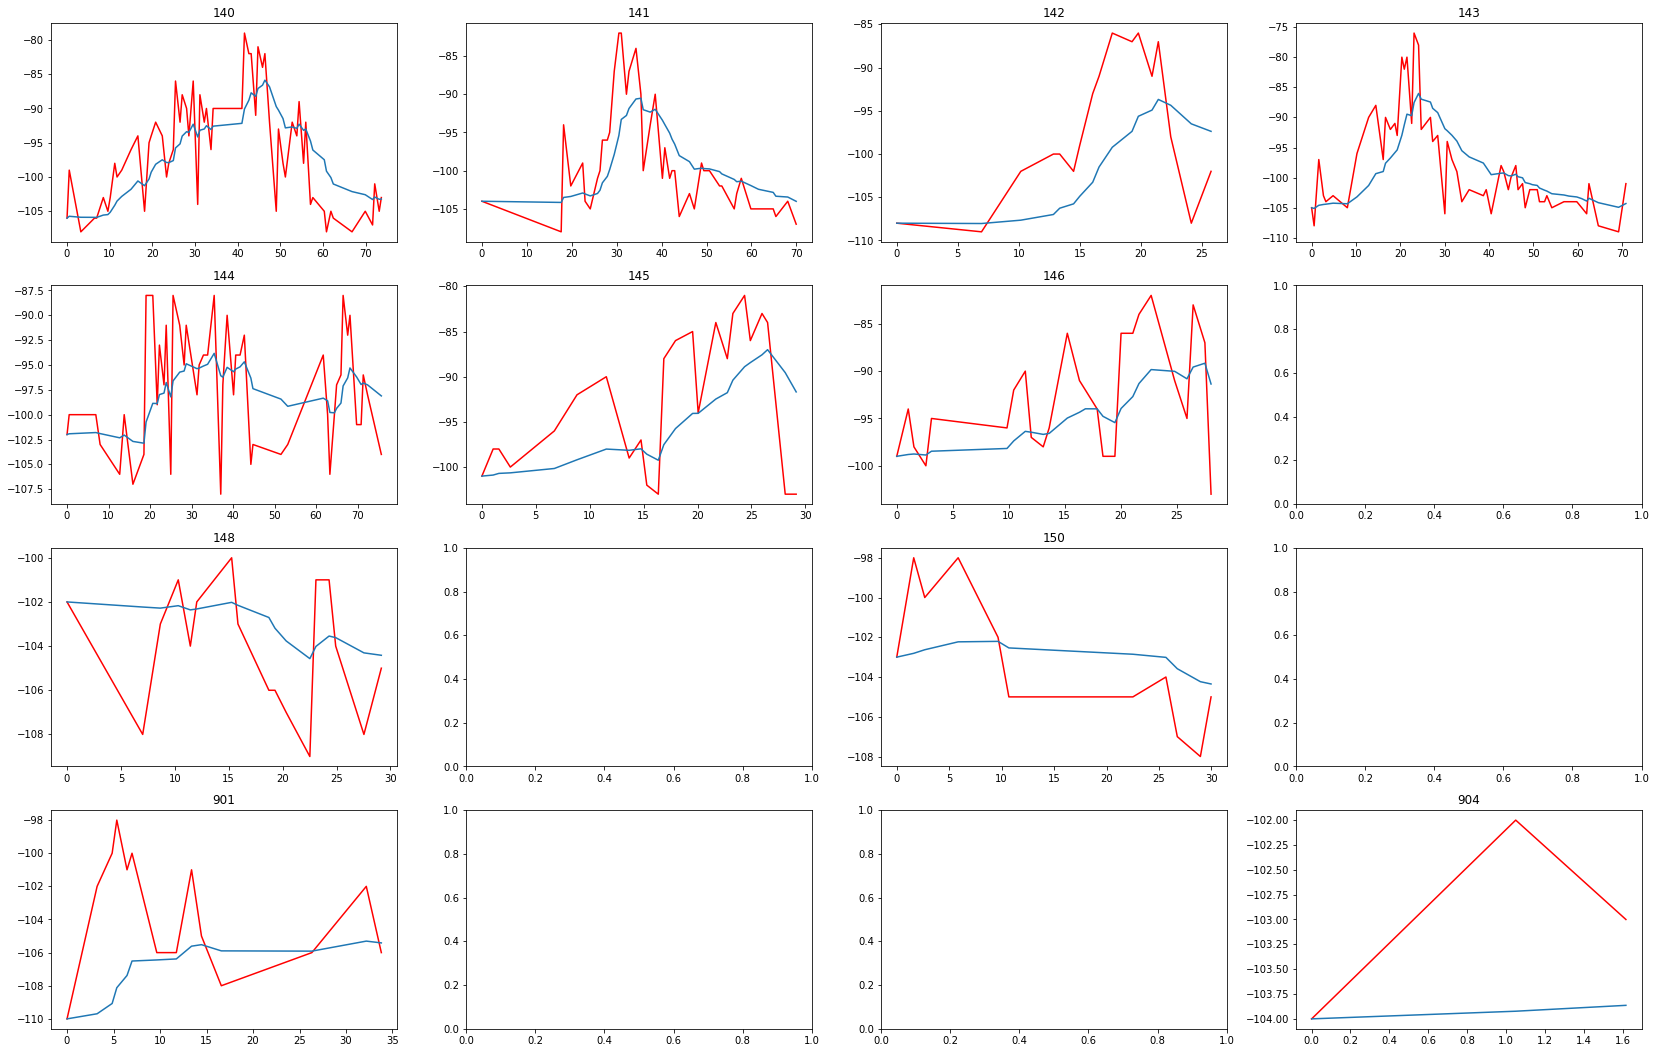

In [123]:
i = 1
k = 150
#kal = kalmanF(Beacon_map[beacon[i][2]],q=6,r=300)
fig = plt.figure(figsize=(40,40),dpi=180)
plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        if len(time_Beacon_map[beacon[i*4+j+k][2]]) ==0 :
            continue
        plt.subplot(4,4,i*4+j+1)
        fig = plt.gcf()
        fig.set_size_inches(28.5, 18.5)
        plt.title(beacon[i*4+j][2])
        plt.plot(np.array(time_Beacon_map[beacon[i*4+j+k][2]])-time_Beacon_map[beacon[i*4+j+k][2]][0],Beacon_map_raw[beacon[i*4+j+k][2]],'r-')
        plt.plot(np.array(time_Beacon_map[beacon[i*4+j+k][2]])-time_Beacon_map[beacon[i*4+j+k][2]][0],Beacon_map[beacon[i*4+j+k][2]],'-')
plt.show()

# 显示距离与强度的关系

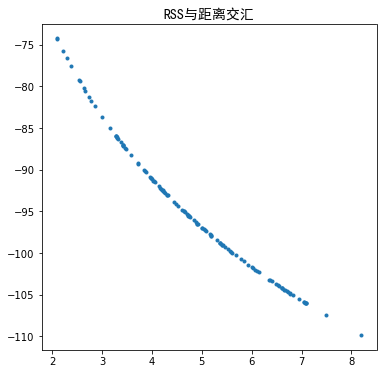

In [141]:
RSS = []
dist = []
for seq in beacon_seq:
    for beacon_res in seq:
        #print(beacon_res)
        if beacon_res[3] < -250:
            continue
        RSS.append(beacon_res[3])
        dist.append(beacon_res[4])
        break

new_dist = []
for i in RSS:
    new_dist.append(EstDist(i,n=6))
plt.figure(figsize=(6,6))
plt.plot(new_dist,RSS,'.')
plt.title("RSS与距离交汇", fontproperties=fontP)
plt.show()

In [49]:
np.min(new_dist)

6.841006914877471

# 几何法求解（梯度下降法）

In [78]:
def Distance2D(Array_point,location):
    if Array_point.shape[1] !=2 or location.shape[1] != 2:
        print("不是二维点")
        return
    return np.array([np.sqrt((i[0]-location[0,0])**2 +(i[1]-location[0,1])**2)   for i in Array_point])

def LOSS(Array_point,location,distance):
    location = np.reshape(location,(1,2))
    curdistance = Distance2D(Array_point , location)
    #print(curdistance)
    for i in range(len(distance)):
        curdistance[i] = np.sqrt( (curdistance[i]-distance[i])**2 )
    return np.sum(curdistance)
def SGDS(points,distance,learnration=0.1, max_iter_count=300,axis='x',init=[0,0]):
    if points.shape[0] !=3 or distance.shape[0] != 3:
        print("不是三个点")
        return
    loss_global = [0,0,0]    
    eval = np.zeros((3,2))
    for i in range(3):
        iter_list=np.zeros((max_iter_count,2))
        iter_list[0,0] = points[i,0]
        iter_list[0,1] = points[i,1]
        loss_list=np.zeros(max_iter_count)
        iter_count = 0
        loss = 0
        loss_Last=1

        #当迭代此时小于最大迭代次数时，进行
        while  iter_count < max_iter_count-1:        
        #print(str(iter_count)+'  location:'+str(iter_list[iter_count])+ '  loss'+str(loss))
            loss = LOSS(points,iter_list[iter_count],distance)
            loss_list[iter_count] = loss
            loss_Last = loss
            iter_count += 1
            if (points[0,0]-iter_list[iter_count-1,0])**2 + (points[0,1]-iter_list[iter_count-1,1])**2 - distance[0]**2>=0:
                iter_list[iter_count,0] += iter_list[iter_count-1,0] + learnration* (points[0,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] += iter_list[iter_count-1,1] + learnration* (points[0,1]-iter_list[iter_count-1,1])
            else:
                iter_list[iter_count,0] += iter_list[iter_count-1,0] - learnration* (points[0,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] += iter_list[iter_count-1,1] - learnration* (points[0,1]-iter_list[iter_count-1,1])                
            if (points[1,0]-iter_list[iter_count-1,0])**2 + (points[1,1]-iter_list[iter_count-1,1])**2 - distance[1]**2>=0:
                iter_list[iter_count,0] +=   learnration* (points[1,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=   learnration* (points[1,1]-iter_list[iter_count-1,1])
            else:
                iter_list[iter_count,0] +=  - learnration* (points[1,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=  - learnration* (points[1,1]-iter_list[iter_count-1,1])
            if (points[2,0]-iter_list[iter_count-1,0])**2 + (points[2,1]-iter_list[iter_count-1,1])**2 - distance[2]**2>=0:
                iter_list[iter_count,0] +=   learnration* (points[2,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=   learnration* (points[2,1]-iter_list[iter_count-1,1]) 
            else:
                iter_list[iter_count,0] +=  - learnration* (points[2,0]-iter_list[iter_count-1,0])
                iter_list[iter_count,1] +=  - learnration* (points[2,1]-iter_list[iter_count-1,1])             

            loss = LOSS(points,iter_list[iter_count],distance)

        minindex = np.argmin(loss_list[0:-1])
        loss_global[i]=(loss_list[minindex])
        eval[i,0] = iter_list[minindex,0]
        eval[i,1] = iter_list[minindex,1]
        #print("迭代位置："+str(minindex))
    minindex = loss_global.index(min(loss_global))
    #print(str(loss_global)+" "+ str(minindex))
    return eval[minindex], loss_global[minindex]    

In [142]:
import math
#根据uid等索引得到信标坐标
def Convert(lst):
    unpack = []
    for i in lst:
        unpack.extend(i)
    res_dct = {unpack[i]+'_'+unpack[i+1]+'_'+unpack[i+2]: unpack[i+3:i+5] for i in range(0, len(unpack), 5)}
    return res_dct
def GetXY(dct,uid):
    try:
        XY = dct[uid]
        return [float(i) for i in XY]
    except KeyError:
        return -1
def EstDist(RSS,tx = -55,n=6):
    return math.pow(10,((-RSS+tx)/10/n))

In [58]:
beacon_dic = Convert(beacon)

# 测试集测试

# #1加权定位

点过少，跳过


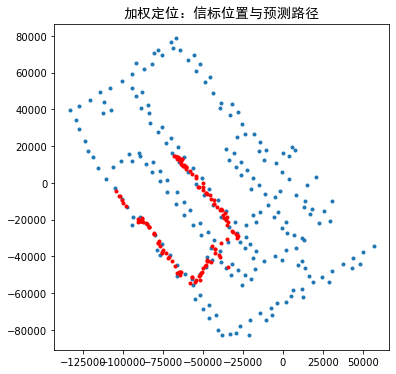

In [132]:
import json

def SumWeightLoc(points,distance):    
    if points.shape[0] !=3 or distance.shape[0] != 3:
        print("不是三个点")
        return
    reverse_dis = 1/distance
    weights = reverse_dis/np.sum(reverse_dis)
    return (points[0,:]*weights[0]+points[1,:]*weights[1]+points[2,:]*weights[2])
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []
for step in beacon_seq:
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
    #print(len(cur_step))        
    if len(cur_step) < 3:
        
        print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = EstDist(cur_step[0][3])*1000
        distance[1] = EstDist(cur_step[1][3])*1000
        distance[2] = EstDist(cur_step[2][3])*1000
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        res_loc.append(SumWeightLoc(points,distance))
        #print(cur_step[:][3])
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = EstDist(sort3[0][3])*1000
        distance[1] = EstDist(sort3[1][3])*1000
        distance[2] = EstDist(sort3[2][3])*1000
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        res_loc.append(SumWeightLoc(points,distance))

    if(res_loc[-1][0]<5 and res_loc[-1][1]<5):
        #print(step,end='')
        #print(points,end='')
        #print(distance)
        pass
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("加权定位：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.show()

In [65]:
one_beacon

['a99bc9df-84ae-418c-bf7b-2dd963fe109f',
 59999,
 36891,
 -94.42740390817073,
 4631.41836863843]

# #2使用梯度下降3点定位

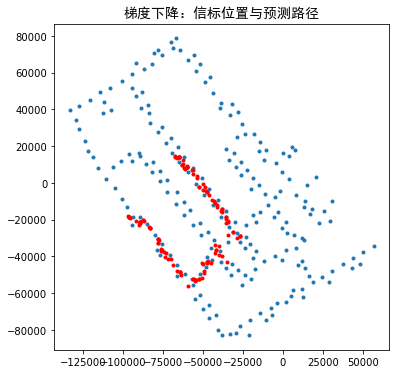

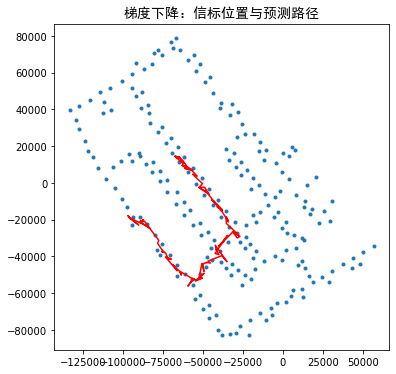

In [143]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []
for i in range(0,len(beacon_seq)):
    step = beacon_seq[i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1:            
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
    #print((cur_step))        
    if len(cur_step) < 3:
        #print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = EstDist(cur_step[0][3])*1000
        distance[1] = EstDist(cur_step[1][3])*1000
        distance[2] = EstDist(cur_step[2][3])*1000
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance,init=points[0])
        res_loc.append([eval[0],eval[1]])
        #print(cur_step)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = EstDist(cur_step[0][3])*1000
        distance[1] = EstDist(cur_step[1][3])*1000
        distance[2] = EstDist(cur_step[2][3])*1000
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        eval, loss = SGDS(points,distance,init=points[0])
        res_loc.append([eval[0],eval[1]])
        #print(sort3)
    #print(distance)
    #print(points)
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
res_loc_array_3p = np.array(res_loc)
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'r.')
#plt.plot(points[:,0],points[:,1],'k.')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'r-')
#plt.plot(points[:,0],points[:,1],'k.')
plt.show() 

# #3卡尔曼滤波

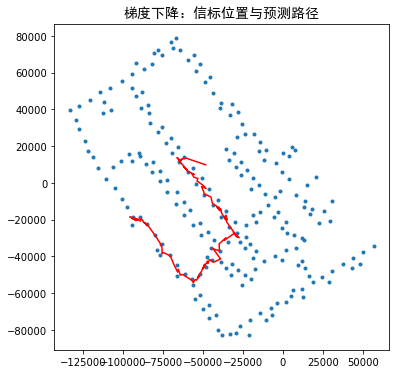

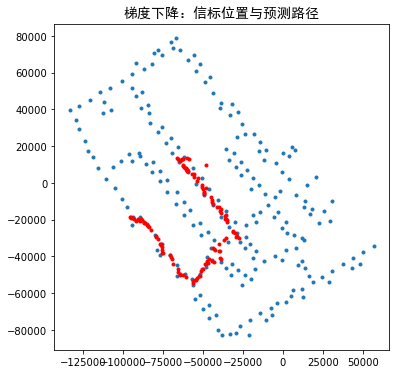

In [144]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = []

evalkk=np.mat([[1637],[1219]])#当前卡尔曼估计值
evalkk1=np.mat([[1628],[1211]])#当前预测值
evalk1k1=np.mat([[0],[0]])#上一次卡尔曼估计值
Pkk=np.mat([[100,0],[0,100]])
Pkk1=np.mat([[100,0],[0,100]])
Pk1k1=np.mat([[100,0],[0,100]])
Q = np.mat([[100,0],[0,100]])
R = np.mat([[200,0],[0,200]])
kalman_T = []
#kalman_T[0] = np.copy(T[0])
T_obs = []
error = []

for step in beacon_seq:
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        if 1:
            evalkk1 = evalkk #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append(eval)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        #eval为当前测量值
        if 1:
        #if i ==0:
        #    evalkk = np.mat(eval).T  #第一次测量值为卡尔曼估计值及预测值
        #    kalman_T.append(eval)
        #    T_obs.append(eval)
        #else:
            evalkk1 = evalkk #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
            #print(kalman_T)
        res_loc.append(eval)

plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(kalman_T)
plt.plot(res_loc_array[1:,0],res_loc_array[1:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[1:,0],res_loc_array[1:,1],'r.')
plt.show() 

# PDR导航+三点定位

In [12]:
from scipy.signal import find_peaks
def CalMapTrans():
    return np.cos(15/180*np.pi),-np.cos(15/180*np.pi)
def CalStepLen():
    return 0.74*10
def GetMapDir():
    return np.pi/4
def PDR(compass_data,accelerometer_data,time_compass,time_accelerometer):
    peaks, _ = find_peaks(accelerometer_data, height=0,prominence=0.06,distance=8)
    x = 0
    y = 0
    stepLen = CalStepLen()
    seq = 0
    #print(peaks)
    #print(len(time_accelerometer))
    #print('---')
    for index in peaks:
        #print(index)
        timestamp = time_accelerometer[index]  
        for i in range(seq,len(time_compass)):
            if timestamp < time_compass[i]:
                #print(time_compass[i])
                seq = i + 1                
                x = x + stepLen * np.sin(compass_data[i]/180*np.pi)
                y = y + stepLen * np.cos(compass_data[i]/180*np.pi)                
                break
            if i == len(time_compass) - 1:
                x = x + stepLen * np.sin(compass_data[-1]/180*np.pi)
                y = y + stepLen * np.cos(compass_data[-1]/180*np.pi)                
    return x,y

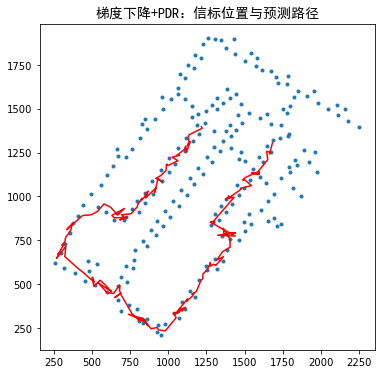

NameError: name 'res_loc_array_3p' is not defined

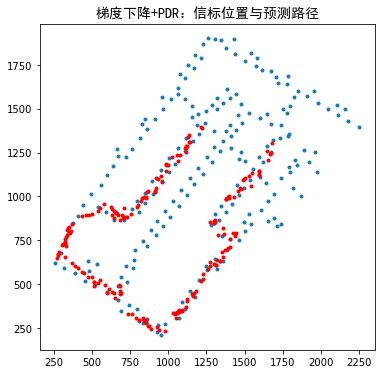

In [17]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[0,0]]
n= 0 
for i in range(0,188):
    step = beacon_seq[n+i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        #print(x*thita1,y*thita2,1)
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance)
        #print('1')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([eval[0]+x*thita1,eval[1]+y*thita2])
        #print(x*thita1,y*thita2)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance)
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([eval[0]+x*thita1,eval[1]+y*thita2])
        #print(x*thita1,y*thita2)
res_loc.remove(res_loc[0])
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'b.')
plt.show() 

In [286]:
compass_seq[3]

[330.18255615234375, 329.0830993652344, 327.94451904296875, 326.9335021972656]

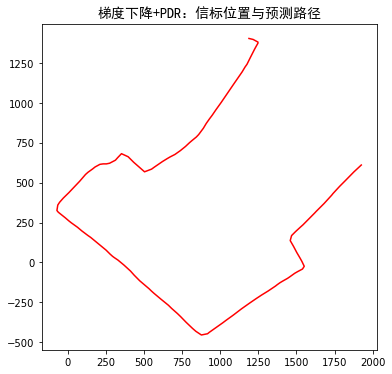

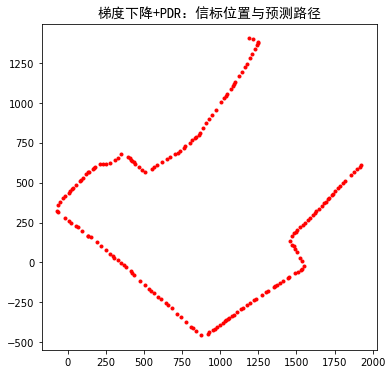

In [349]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[res_loc_array_3p[0][0],res_loc_array_3p[0][1]]]
eval = [0,0]
for i in range(188):
    step = beacon_seq[i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance)
        #print('1')
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance)
        x ,y = PDR(compass_seq[i],accelerometer_seq[i],time_seq_compass[i],time_seq_accelerometer[i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])

plt.figure(figsize=(6,6))
#plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
#plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.show() 

# PDR导航+三点定位+kalman

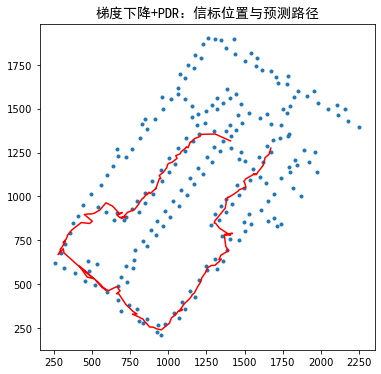

NameError: name 'res_loc_array_3p' is not defined

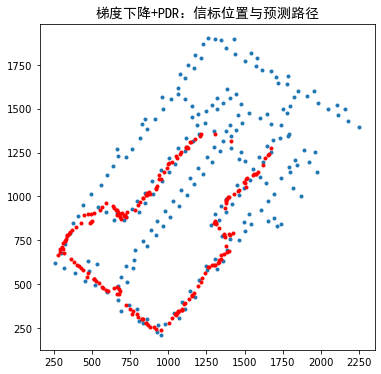

In [34]:
# 将step按RSS排序
def takeRSS(elem):
    return elem[3]
res_loc = [[0,0]]
n= 0 

evalkk=np.mat([[1637],[1219]])#当前卡尔曼估计值
evalkk1=np.mat([[1628],[1211]])#当前预测值
evalk1k1=np.mat([[0],[0]])#上一次卡尔曼估计值
Pkk=np.mat([[100,0],[0,100]])
Pkk1=np.mat([[100,0],[0,100]])
Pk1k1=np.mat([[100,0],[0,100]])
Q = np.mat([[500,0],[0,500]])
R = np.mat([[500,0],[0,500]])
kalman_T = []

for i in range(0,188):
    step = beacon_seq[n+i]
    cur_step = []
    for one_beacon in step:
        if GetXY(beacon_dic,one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2])) != -1 :
            cur_step.append(one_beacon)
            #print(one_beacon[0].lower()+'_'+str(one_beacon[1])+'_'+str(one_beacon[2]))
            
    if len(cur_step) < 3:
        #print('点过少，跳过')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        res_loc.append([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2])
        continue
        evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
        Pkk1 = Pk1k1 + Q #此次协方差预测值
        Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
        evalkk = evalkk1 + np.dot(Kk,np.mat([res_loc[-1][0]+x*thita1,res_loc[-1][1]+y*thita2]).T - evalkk1)#当前卡尔曼估计值
        Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
        
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        #print(x*thita1,y*thita2,1)
        continue

    elif len(cur_step) == 3:
        distance = np.zeros(3)
        points = np.ones((3,2))
        distance[0] = cur_step[0][4]
        distance[1] = cur_step[1][4]
        distance[2] = cur_step[2][4]
        points[0] = GetXY(beacon_dic,cur_step[0][0].lower()+'_'+str(cur_step[0][1])+'_'+str(cur_step[0][2]))
        points[1] = GetXY(beacon_dic,cur_step[1][0].lower()+'_'+str(cur_step[1][1])+'_'+str(cur_step[1][2]))
        points[2] = GetXY(beacon_dic,cur_step[2][0].lower()+'_'+str(cur_step[2][1])+'_'+str(cur_step[2][2]))
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        #print('1')
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        if 1:
            evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval+[x*thita1,y*thita2]).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        #last_step = [x*thita1,y*thita2]
        #print(x*thita1,y*thita2)
    elif len(cur_step) >3:       
        cur_step.sort(key=takeRSS,reverse = True)       
        sort3 = cur_step[0:3]
        distance = np.zeros(3)
        points = np.zeros((3,2))
        distance[0] = sort3[0][4]
        distance[1] = sort3[1][4]
        distance[2] = sort3[2][4]
        points[0] = GetXY(beacon_dic,sort3[0][0].lower()+'_'+str(sort3[0][1])+'_'+str(sort3[0][2]))
        points[1] = GetXY(beacon_dic,sort3[1][0].lower()+'_'+str(sort3[1][1])+'_'+str(sort3[1][2]))
        points[2] = GetXY(beacon_dic,sort3[2][0].lower()+'_'+str(sort3[2][1])+'_'+str(sort3[2][2]))
        #print('2')
        eval, loss = SGDS(points,distance,max_iter_count=100,axis='x',init=points[0])
        x ,y = PDR(compass_seq[n+i],accelerometer_seq[n+i],time_seq_compass[n+i],time_seq_accelerometer[n+i])
        thita1 , thita2 = CalMapTrans()
        if 1:
            evalkk1 = evalkk    #上一次的卡尔曼估计值为预测值
            Pkk1 = Pk1k1 + Q #此次协方差预测值
            Kk = np.dot(Pkk1,(Pkk1+R).I)#最优卡尔曼估计
            evalkk = evalkk1 + np.dot(Kk,np.mat(eval+[x*thita1,y*thita2]).T - evalkk1)#当前卡尔曼估计值
            Pkk1 = Pkk1 - np.dot(Kk,Pkk1)#当前卡尔曼协方差估计值
            kalman_T.append([evalkk[0,0],evalkk[1,0]])
            T_obs.append(eval)
        res_loc.append([evalkk[0,0],evalkk[1,0]])
        
        #print(x*thita1,y*thita2)
res_loc.remove(res_loc[0])
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r-')
plt.show()  
plt.figure(figsize=(6,6))
plt.plot(Beacon_xy[:,0],Beacon_xy[:,1],'.')
plt.title("梯度下降+PDR：信标位置与预测路径", fontproperties=fontP)
#res_loc_array = np.array(res_loc)
plt.plot(res_loc_array[:,0],res_loc_array[:,1],'r.')
plt.plot(res_loc_array_3p[:,0],res_loc_array_3p[:,1],'b.')
plt.show() 

In [89]:
n=25
#print(time_seq_accelerometer[n],accelerometer_seq[n])

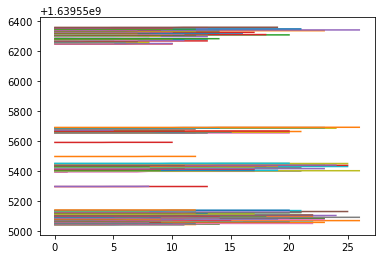

In [107]:
for i in range(24,200):
    plt.plot(time_seq_beacon[i])
plt.show()

In [108]:
time_seq_beacon

[[1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972,
  1639554981.972],
 [1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554982.626,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412,
  1639554983.412],
 [1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469,
  1639554984.469],
 [1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  1639554986.456,
  16395